In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext watermark
%watermark -v -p numpy,pandas,pycocotools,torch,torchvision,detectron2,cv2

CPython 3.6.9
IPython 7.16.1

numpy 1.18.5
pandas 1.0.4
pycocotools 2.0.2
torch 1.6.0.dev20200609+cu101
torchvision 0.7.0.dev20200609+cu101
detectron2 0.2.1
cv2 4.4.0


In [2]:
# ! pip install detectron2

In [3]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import glob

import os
import numpy as np
import cv2
import random
import itertools
import pandas as pd
import json
import PIL.Image as Image

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED);

In [42]:
from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT, K12AI_NBDATA_ROOT, K12AI_PRETRAINED_ROOT
from k12libs.utils.nb_easy import k12ai_set_notebook
from k12libs.utils.nb_easy import k12ai_get_top_dir
k12ai_set_notebook(cellw=95)

## Read Data

In [6]:
dataset = 'licenseplates'
data_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', dataset)
imgs_path = os.path.join(data_root, "images")
output_dir = os.path.join(K12AI_NBDATA_ROOT, 'cv', 'det', 'ouput')

df = pd.read_csv(os.path.join(data_root, 'annotations.csv'))
df.head()

,file_name,width,height,x_min,y_min,x_max,y_max,class_name
0,105zx.jpg,640,480,282,209,416,259,licenseplate
1,t65qy.jpg,640,480,282,205,411,244,licenseplate
2,1vdml.jpg,640,480,278,195,427,241,licenseplate
3,5pmdj.jpg,640,480,277,172,396,209,licenseplate
4,8j6at.jpg,640,480,276,131,404,178,licenseplate


## Train/Val Sample

In [7]:
unique_files = df.file_name.unique()

train_files = set(np.random.choice(unique_files, int(len(unique_files) * 0.8), replace=False))
train_df = df[df.file_name.isin(train_files)]
test_df = df[~df.file_name.isin(train_files)]

train_df.head()

,file_name,width,height,x_min,y_min,x_max,y_max,class_name
0,105zx.jpg,640,480,282,209,416,259,licenseplate
3,5pmdj.jpg,640,480,277,172,396,209,licenseplate
4,8j6at.jpg,640,480,276,131,404,178,licenseplate
5,7qsgi.jpg,1792,1312,727,566,1129,682,licenseplate
6,lh1au.jpg,1792,1312,627,575,1110,675,licenseplate


In [8]:
classes = df.class_name.unique().tolist()
classes

['licenseplate']

In [9]:
def create_dataset_dicts(df, classes):
    dataset_dicts = []
    for image_id, img_name in enumerate(df.file_name.unique()):

        record = {}

        image_df = df[df.file_name == img_name]

        file_path = f'{imgs_path}/{img_name}'
        # if not os.path.exists(file_path):
        #     print(file_path)
        record["file_name"] = file_path
        record["image_id"] = image_id
        record["height"] = int(image_df.iloc[0].height)
        record["width"] = int(image_df.iloc[0].width)

        objs = []
        for _, row in image_df.iterrows():
            xmin = int(row.x_min)
            ymin = int(row.y_min)
            xmax = int(row.x_max)
            ymax = int(row.y_max)

            poly = [
                (xmin, ymin), (xmax, ymin), 
                (xmax, ymax), (xmin, ymax)
            ]
            poly = list(itertools.chain.from_iterable(poly))

            obj = {
                "bbox": [xmin, ymin, xmax, ymax],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(row.class_name),
                "iscrowd": 0
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [10]:
len(train_df.file_name.unique()), len(test_df.file_name.unique())

(109, 28)

In [11]:
for d in ["train", "val"]:
    DatasetCatalog.register("lp_" + d, lambda d=d: create_dataset_dicts(train_df if d == "train" else test_df, classes))
    MetadataCatalog.get("lp_" + d).set(thing_classes=classes)

statement_metadata = MetadataCatalog.get("lp_train")
statement_metadata

namespace(name='lp_train', thing_classes=['licenseplate'])

In [12]:
class CocoTrainer(DefaultTrainer):
  
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        os.makedirs(output_dir, exist_ok=True)
        return COCOEvaluator(dataset_name, cfg, distributed=False, output_dir=output_dir)

In [14]:
cfg = get_cfg()

cfg.merge_from_file(
  model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
    # "COCO-Detection/retinanet_R_50_FPN_3x.yaml"
  )
)

weight = 'model_final_68b088.pkl'

cfg.MODEL.WEIGHTS = os.path.join(f'{K12AI_PRETRAINED_ROOT}/cv/model_zoo/{weight}')

cfg.DATASETS.TRAIN = ("lp_train",)
cfg.DATASETS.TEST = ("lp_val",)
cfg.DATALOADER.NUM_WORKERS = 4

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # len(classes)

cfg.TEST.EVAL_PERIOD = 500

cfg.OUTPUT_DIR = output_dir

os.makedirs(output_dir, exist_ok=True)

In [15]:
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[09/17 21:47:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[09/17 21:47:48 d2.data.build]: Removed 0 images with no usable annotations. 109 images left.
[09/17 21:47:48 d2.data.build]: Distribution of instances among all 1 categories:
|   category   | #instances   |
|:------------:|:-------------|
| licenseplate | 109          |
|              |              |
[09/17 21:47:48 d2.data.common]: Serializing 109 elements to byte tensors and concatenating them all ...
[09/17 21:47:48 d2.data.common]: Serialized dataset takes 0.03 MiB
[09/17 21:47:48 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[09/17 21:47:48 d2.data.build]: Using training sampler TrainingSampler
[09/17 21:47:49 d2.engine.train_loop]: Starting training from iteration 150
[09/17 21:48:07 d2.utils.events]:  eta: 0:38:34  iter: 159  total_loss: 0.791  loss_cls: 0.05548  loss_box_reg: 0.3519  loss_mask: 0.3705  loss_rpn_cls: 0.002588  loss_rpn_loc: 0.00

[09/17 21:57:53 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
COCOeval_opt.evaluate() finished in 0.01 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.803
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.803
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.820
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.843
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all 

[09/17 22:10:51 d2.utils.events]:  eta: 0:15:56  iter: 959  total_loss: 0.1814  loss_cls: 0.01041  loss_box_reg: 0.1024  loss_mask: 0.06554  loss_rpn_cls: 1.138e-06  loss_rpn_loc: 0.00145  time: 1.6968  data_time: 0.0159  lr: 0.00095904  max_mem: 9616M
[09/17 22:11:25 d2.utils.events]:  eta: 0:15:20  iter: 979  total_loss: 0.1883  loss_cls: 0.01347  loss_box_reg: 0.1086  loss_mask: 0.06704  loss_rpn_cls: 8.099e-06  loss_rpn_loc: 0.001529  time: 1.6965  data_time: 0.0158  lr: 0.00097902  max_mem: 9616M
[09/17 22:11:59 d2.data.common]: Serializing 28 elements to byte tensors and concatenating them all ...
[09/17 22:11:59 d2.data.common]: Serialized dataset takes 0.01 MiB
[09/17 22:11:59 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/17 22:11:59 d2.evaluation.evaluator]: Start inference on 28 images
[09/17 22:12:01 d2.evaluation.evaluator]: Inference done 11/28. 0.1799 s / img. ETA=0:00:

[09/17 22:18:19 d2.utils.events]:  eta: 0:08:16  iter: 1219  total_loss: 0.1268  loss_cls: 0.01017  loss_box_reg: 0.06072  loss_mask: 0.05778  loss_rpn_cls: 8.664e-06  loss_rpn_loc: 0.001257  time: 1.6969  data_time: 0.0157  lr: 5e-05  max_mem: 9616M
[09/17 22:18:53 d2.utils.events]:  eta: 0:07:41  iter: 1239  total_loss: 0.1257  loss_cls: 0.009453  loss_box_reg: 0.05847  loss_mask: 0.05551  loss_rpn_cls: 1.512e-05  loss_rpn_loc: 0.001169  time: 1.6969  data_time: 0.0146  lr: 5e-05  max_mem: 9616M
[09/17 22:19:26 d2.utils.events]:  eta: 0:07:05  iter: 1259  total_loss: 0.1367  loss_cls: 0.01148  loss_box_reg: 0.06358  loss_mask: 0.06164  loss_rpn_cls: 1.083e-05  loss_rpn_loc: 0.001175  time: 1.6964  data_time: 0.0154  lr: 5e-05  max_mem: 9616M
[09/17 22:20:01 d2.utils.events]:  eta: 0:06:30  iter: 1279  total_loss: 0.1283  loss_cls: 0.01431  loss_box_reg: 0.06179  loss_mask: 0.05358  loss_rpn_cls: 1.963e-06  loss_rpn_loc: 0.001046  time: 1.6968  data_time: 0.0153  lr: 5e-05  max_mem: 9

[09/17 22:26:25 d2.evaluation.testing]: copypaste: 82.2183,100.0000,100.0000,nan,82.5265,82.9043
[09/17 22:26:25 d2.evaluation.testing]: copypaste: Task: segm
[09/17 22:26:25 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[09/17 22:26:25 d2.evaluation.testing]: copypaste: 82.3719,100.0000,100.0000,nan,82.5221,83.3993
[09/17 22:26:25 d2.utils.events]:  eta: 0:00:01  iter: 1499  total_loss: 0.1225  loss_cls: 0.007253  loss_box_reg: 0.05499  loss_mask: 0.05549  loss_rpn_cls: 2.681e-06  loss_rpn_loc: 0.0009791  time: 1.6952  data_time: 0.0152  lr: 5e-05  max_mem: 9616M
[09/17 22:26:25 d2.engine.hooks]: Overall training speed: 1347 iterations in 0:38:05 (1.6965 s / it)
[09/17 22:26:25 d2.engine.hooks]: Total training time: 0:38:31 (0:00:26 on hooks)


In [16]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)

In [ ]:
evaluator = COCOEvaluator("lp_val", cfg, False, output_dir=output_dir)
val_loader = build_detection_test_loader(cfg, "lp_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

In [20]:
test_image_paths = test_df.file_name.unique()
test_image_paths

array(['t65qy.jpg', '1vdml.jpg', 'gcbar.jpg', 'obgce.jpg', 'zb35o.jpg',
       'x70yk.jpg', '8q4y0.jpg', 'rbrte.jpg', 'plw9k.jpg', '2uuuk.jpg',
       '15bo2.jpg', '54ddl.jpg', 'n90o3.jpg', '09acj.jpg', 'sul4m.jpg',
       'm8tyl.jpg', 'kkwcd.jpg', 'edify.jpg', 'mx1we.jpg', 'tl7i2.jpg',
       's018p.jpg', 'nb65z.jpg', 'm87g8.jpg', 'ihr2w.jpg', 'i1twi.jpg',
       'gozm6.jpg', 'bli80.jpg', 'e9q1y.jpg'], dtype=object)

In [21]:
for clothing_image in test_image_paths[:2]:
    file_path = f'{imgs_path}/{clothing_image}'
    im = cv2.imread(file_path)
    outputs = predictor(im)
    v = Visualizer(
        im[:, :, ::-1],
        metadata=statement_metadata, 
        scale=1., 
        instance_mode=ColorMode.IMAGE
    )
    instances = outputs["instances"].to("cpu")
    v = v.draw_instance_predictions(instances)
    result = v.get_image()[:, :, ::-1]
    file_name = os.path.basename(clothing_image)
    write_res = cv2.imwrite(f'{output_dir}/{file_name}', result)

In [22]:
annotated_images = [f'{output_dir}/{f}' for f in test_df.file_name.unique()]
annotated_images[:2]

['/data/nb_data/cv/det/ouput/t65qy.jpg',
 '/data/nb_data/cv/det/ouput/1vdml.jpg']

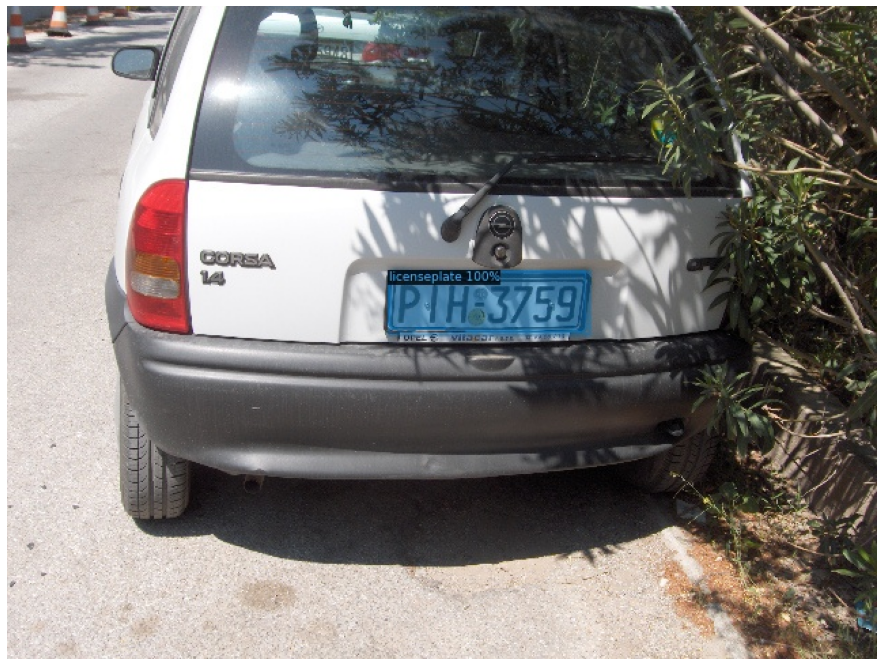

In [23]:
plt.figure(figsize=(16, 12))

img = cv2.cvtColor(cv2.imread(annotated_images[1]), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off');

In [26]:
img.shape

(480, 640, 3)

In [38]:
im = cv2.imread('/data/datasets/cv/CCPD2019/ccpd_rotate/0500-21_15-214&373_445&554-436&554_214&467_223&373_445&460-0_0_6_5_29_24_33-132-78.jpg')
im[:, ::-1].shape

(1160, 720, 3)

In [41]:
f = os.path.join(K12AI_NBDATA_ROOT, 'cv/assets/images/lp.jpeg')
f

'/data/nb_data/cv/assets/images/lp.jpeg'

0


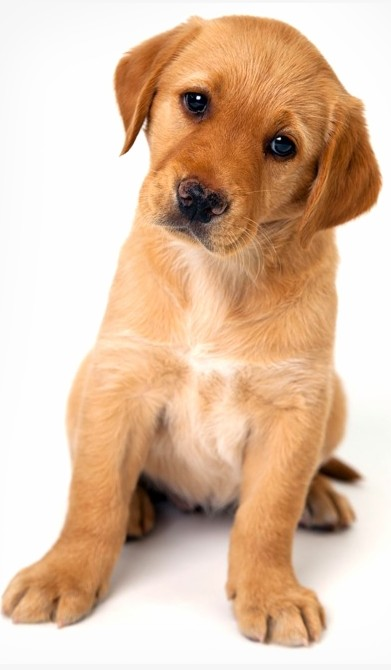

In [49]:
# im = cv2.imread('/data/datasets/cv/licenseplates/images/105zx.jpg')
# im = cv2.imread('/data/datasets/cv/CCPD2019/ccpd_base/0163888888889-90_87-217&469_478&535-485&548_237&546_232&467_480&469-0_0_30_15_31_31_26-96-95.jpg')
# im = cv2.imread('/data/datasets/cv/CCPD2019/ccpd_rotate/0500-21_15-214&373_445&554-436&554_214&467_223&373_445&460-0_0_6_5_29_24_33-132-78.jpg')
# im = cv2.imread(os.path.join(k12ai_get_top_dir(), 'cv/assets/images/lp.jpeg'))
im = cv2.imread(os.path.join(k12ai_get_top_dir(), 'assets/images/puppy.jpeg'))

outputs = predictor(im)
v = Visualizer(
    im[:, :, ::-1],
    scale=1., 
    instance_mode=ColorMode.IMAGE
)
print(len(outputs['instances'].to('cpu')))
instances = outputs["instances"].to("cpu")
v = v.draw_instance_predictions(instances)
# result = v.get_image()[:, :, ::-1]
# cv2.imwrite(f'{output_dir}/test_det.jpg', result)

# plt.figure(figsize=(10, 16))
# img = cv2.cvtColor(cv2.imread(f'{output_dir}/test_det.jpg'), cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# plt.axis('off');

img = Image.fromarray(v.get_image())
img.resize((int(img.size[0]), int(img.size[1])))

## References

1. https://medium.com/towards-artificial-intelligence/number-plate-detection-recognition-detectron-v2-5ddad2a532d0